In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys, os, sys, math
from pathlib import Path
import matplotlib.pyplot as plt, numpy as np
from jfi import jaxm

root_path = Path("").absolute().parent
if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))
import pmpc
from dubins_car import f_np as f_fn, fx_np as fx_fn, fu_np as fu_fn
import jaxopt
from pmpc.experimental import scp_solve, solve_problems
from pmpc.experimental.second_order_solvers import ConvexSolver
print(jaxm.zeros(()).dtype)
print(jaxm.zeros(()).device())

float64
TFRT_CPU_0


In [3]:
P, q = jaxm.randn((100, 100)), jaxm.randn((100,))
P = P @ P.T

def obj_fn(x):
    J = jaxm.sum(x * (P @ x)) / 2 + jaxm.sum(q * x) + jaxm.sum(-jaxm.log(x))
    J = jaxm.where(jaxm.any(x < 0.0), jaxm.inf, J)
    return J
#print(f"best_loss = {obj_fn(jaxm.linalg.solve(P, -q))}")

In [4]:
solver = ConvexSolver(obj_fn, jit=True, maxiter=100, tol=1e-3, linesearch="binary_search", maxls=20)
params = jaxm.ones((100,))
state = solver.init_state(params)
for it in range(10):
    params, state = solver.update(params, state)
    print(f"{jaxm.norm(params), state.best_loss}")
print()
solver = ConvexSolver(obj_fn, jit=True, maxiter=100, tol=1e-3, linesearch="scan", maxls=20)
params = jaxm.ones((100,))
state = solver.init_state(params)
for it in range(10):
    params, state = solver.update(params, state)
    print(f"{jaxm.norm(params), state.best_loss}")

(Array(7.40211811, dtype=float64), Array(1862.6094575, dtype=float64))
(Array(3.97860157, dtype=float64), Array(413.0191017, dtype=float64))
(Array(2.74487887, dtype=float64), Array(243.87424927, dtype=float64))
(Array(2.37476795, dtype=float64), Array(226.44140308, dtype=float64))
(Array(2.40364033, dtype=float64), Array(226.33721136, dtype=float64))
(Array(2.40355642, dtype=float64), Array(226.33692735, dtype=float64))
(Array(2.40355656, dtype=float64), Array(226.33692734, dtype=float64))
(Array(2.40355656, dtype=float64), Array(226.33692734, dtype=float64))
(Array(2.40355656, dtype=float64), Array(226.33692734, dtype=float64))
(Array(2.40355656, dtype=float64), Array(226.33692734, dtype=float64))

(Array(7.58751074, dtype=float64), Array(1980.41415605, dtype=float64))
(Array(5.90466573, dtype=float64), Array(1079.68709975, dtype=float64))
(Array(4.73464871, dtype=float64), Array(635.78808647, dtype=float64))
(Array(3.9334848, dtype=float64), Array(420.01906447, dtype=float64))
(Arra

In [23]:
def f_fx_fu_fn(X_prev, U_prev):
    X_prev, U_prev = np.array(X_prev), np.array(U_prev)
    x, u, p = X_prev, U_prev, np.array([1.0, 1.0, 0.3])
    return f_fn(x, u, p), fx_fn(x, u, p), fu_fn(x, u, p)

In [46]:
M, N, xdim, udim = 1000, 20, 4, 2

Q = np.tile(np.eye(xdim), (N, 1, 1))
R = np.tile(1e-2 * np.eye(udim), (N, 1, 1))
x0 = np.tile(np.ones(xdim), (1,))
X_ref, U_ref = np.zeros((N, xdim)), np.zeros((N, udim))
X_prev, U_prev = np.zeros((N, xdim)), np.zeros((N, udim))
u_lim = 1.0
u_l, u_u = -u_lim * np.ones((N, udim)), u_lim * np.ones((N, udim))

Q, R, x0, X_ref, U_ref, X_prev, U_prev, u_l, u_u = [
    np.tile(z, (M,) + (1,) * z.ndim) for z in [Q, R, x0, X_ref, U_ref, X_prev, U_prev, u_l, u_u]
]

opts = dict(verbose=True, u_l=u_l, u_u=u_u, reg_x=1e0, reg_u=1e0)
args = (f_fx_fu_fn, Q, R, x0, X_ref, U_ref, X_prev, U_prev)
solver_settings = dict(smooth_alpha=1e3, solver="CVX")


def extra_cvx_cost_fn(*args, **kw):
    return 0.0


problems = [
    dict(
        f_fx_fu_fn=f_fx_fu_fn,
        Q=Q[i],
        R=R[i],
        x0=x0[i],
        X_ref=X_ref[i],
        U_ref=U_ref[i],
        X_prev=X_prev[i],
        U_prev=U_prev[i],
        u_l=u_l[i],
        u_u=u_u[i],
        reg_x=opts["reg_x"],
        reg_u=opts["reg_u"],
        solver_settings=solver_settings,
        verbose=True,
        max_it=10,
        extra_cvx_cost_fn=extra_cvx_cost_fn,
    )
    for i in range(Q.shape[0])
]

In [47]:
sols = solve_problems(problems)

Stacking problems took 3.7856e-02 s
+------+------------+------------+------------+----------+----------+----------+
|  it  |   elaps    |    obj     |   resid    |  reg_x   |  reg_u   |  alpha   |
+------+------------+------------+------------+----------+----------+----------+
| 0001 |  6.254e-01 |  4.703e+01 |  1.622e+00 |  1.0e+00 |  1.0e+00 |  1.0e-01 |
| 0002 |  9.139e-01 |  2.724e-01 |  4.994e-01 |  1.0e+00 |  1.0e+00 |  1.0e+00 |
| 0003 |  1.200e+00 |  1.583e+00 |  2.456e+00 |  1.0e+00 |  1.0e+00 |  1.0e+01 |
| 0004 |  1.488e+00 |  8.640e-01 |  7.308e-01 |  1.0e+00 |  1.0e+00 |  1.0e+02 |
| 0005 |  1.777e+00 |  8.412e-01 |  3.786e-01 |  1.0e+00 |  1.0e+00 |  1.0e+03 |
| 0006 |  2.064e+00 |  6.661e-01 |  1.003e+00 |  1.0e+00 |  1.0e+00 |  1.0e+03 |
| 0007 |  2.350e+00 |  8.870e-01 |  6.294e-01 |  1.0e+00 |  1.0e+00 |  1.0e+03 |
| 0008 |  2.636e+00 |  7.990e-01 |  2.158e-01 |  1.0e+00 |  1.0e+00 |  1.0e+03 |
| 0009 |  2.923e+00 |  7.854e-01 |  1.791e-01 |  1.0e+00 |  1.0e+00 |  1.

In [7]:
X, U, data = scp_solve(
    *args, max_it=100, res_tol=1e-12, **opts, solver_settings=dict(smooth_alpha=1e3, solver="CVX")
)

+------+------------+------------+------------+----------+----------+----------+
|  it  |   elaps    |    obj     |   resid    |  reg_x   |  reg_u   |  alpha   |
+------+------------+------------+------------+----------+----------+----------+
| 0001 |  4.419e+00 |  4.703e+01 |  1.622e+00 |  1.0e+00 |  1.0e+00 |  1.0e-01 |
| 0002 |  4.694e+00 |  2.917e-01 |  5.150e-01 |  1.0e+00 |  1.0e+00 |  1.0e+00 |
| 0003 |  4.873e+00 |  1.568e+00 |  2.485e+00 |  1.0e+00 |  1.0e+00 |  1.0e+01 |
| 0004 |  5.053e+00 |  8.585e-01 |  7.381e-01 |  1.0e+00 |  1.0e+00 |  1.0e+02 |
| 0005 |  5.236e+00 |  8.457e-01 |  3.739e-01 |  1.0e+00 |  1.0e+00 |  1.0e+03 |
| 0006 |  5.417e+00 |  8.173e-01 |  1.919e-01 |  1.0e+00 |  1.0e+00 |  1.0e+03 |
| 0007 |  5.598e+00 |  8.088e-01 |  1.588e-01 |  1.0e+00 |  1.0e+00 |  1.0e+03 |
| 0008 |  5.782e+00 |  8.045e-01 |  1.317e-01 |  1.0e+00 |  1.0e+00 |  1.0e+03 |
| 0009 |  5.963e+00 |  8.018e-01 |  1.095e-01 |  1.0e+00 |  1.0e+00 |  1.0e+03 |
| 0010 |  6.146e+00 |  8.000

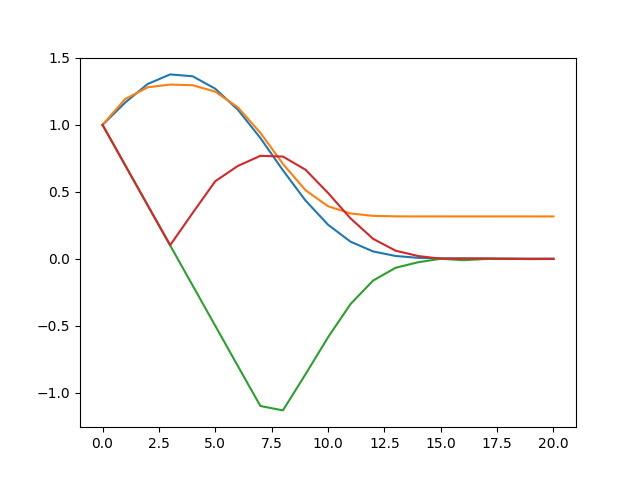

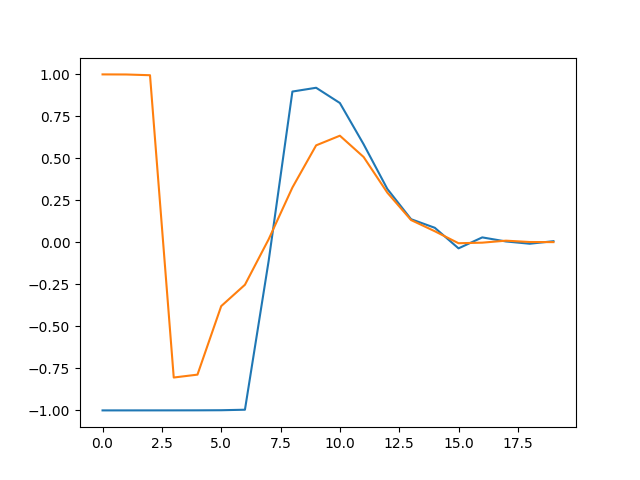

In [8]:
idx = 2
plt.figure(4356675)
plt.clf()
for r in range(X.shape[-1]):
    plt.plot(X[idx, :, r], label=f"x{r}")
plt.show()
plt.figure(4534534)
plt.clf()
for r in range(U.shape[-1]):
    plt.plot(U[idx, :, r], label=f"u{r}")
plt.show()

In [9]:
opts["solver_settings"] = dict(solver="ecos", smooth_alpha=1e3, smooth_cstr="logbarrier")
X2, U2, data = pmpc.solve(
    *[arg[0] if hasattr(arg, "shape") else arg for arg in list(args)[:-2] + [X[..., 1:, :], U]],
    max_it=50,
    **dict(opts, reg_x=1e1),
)

+------+------------+------------+------------+------------+------------+
|  it  |   elaps    |    obj     |   resid    |   reg_x    |   reg_u    |
+------+------------+------------+------------+------------+------------+
| 0001 |  2.334e+01 |  1.616e+00 |  9.117e-03 |  1.000e+01 |  1.000e+00 |
| 0002 |  2.335e+01 |  1.617e+00 |  1.586e-03 |  1.000e+01 |  1.000e+00 |
| 0003 |  2.336e+01 |  1.617e+00 |  1.479e-03 |  1.000e+01 |  1.000e+00 |
| 0004 |  2.336e+01 |  1.617e+00 |  1.438e-03 |  1.000e+01 |  1.000e+00 |
| 0005 |  2.337e+01 |  1.617e+00 |  1.395e-03 |  1.000e+01 |  1.000e+00 |
| 0006 |  2.338e+01 |  1.617e+00 |  1.354e-03 |  1.000e+01 |  1.000e+00 |
| 0007 |  2.339e+01 |  1.617e+00 |  1.315e-03 |  1.000e+01 |  1.000e+00 |
| 0008 |  2.339e+01 |  1.617e+00 |  1.277e-03 |  1.000e+01 |  1.000e+00 |
| 0009 |  2.340e+01 |  1.617e+00 |  1.241e-03 |  1.000e+01 |  1.000e+00 |
| 0010 |  2.341e+01 |  1.617e+00 |  1.205e-03 |  1.000e+01 |  1.000e+00 |
| 0011 |  2.341e+01 |  1.617e+00 |  1.

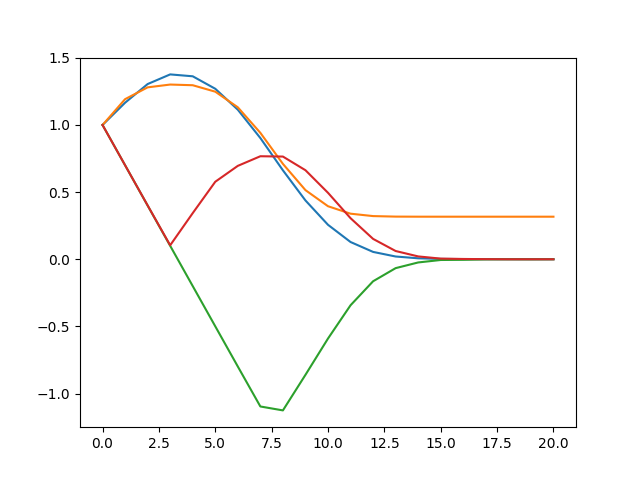

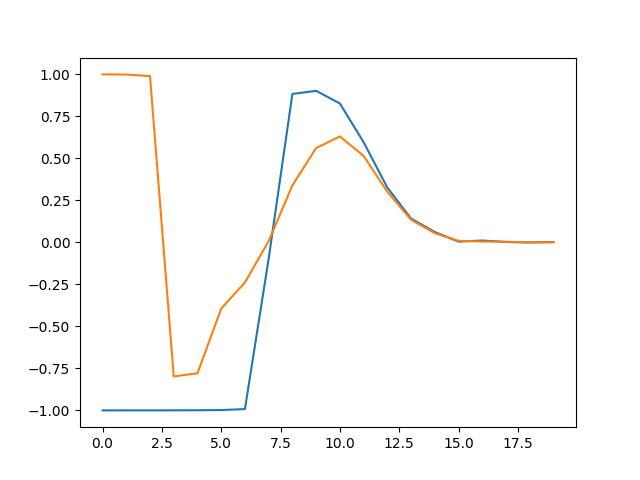

In [10]:
plt.figure(663454475)
plt.clf()
for r in range(X2.shape[1]):
    plt.plot(X2[:, r], label=f"x{r}")
plt.show()
plt.figure(45435534)
plt.clf()
for r in range(U2.shape[1]):
    plt.plot(U2[:, r], label=f"u{r}")
plt.show()